# CMA/ES. Sigma Base, 9th try: LL median, fixed cov, lapse + sigma_base

Trying to use Median LL instead of LL9X. Seemed to behave better in random coverage, nice correlation with the other metrics, so let's see...

# !! USED IN THESIS !!

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io


from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [3]:
from plotly import offline as py
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


## Reload data

In [4]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_9try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217/
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-d58fa444-51aa-49cf-a304-3566d1ea62b3.npy').item()

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_9try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217


In [5]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [6]:
parameter_names_sorted

['M', 'lapse_rate', 'ratio_conj', 'sigma_baseline', 'sigmax']

In [7]:
metric = 'dist_ll_median'

df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                       (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                      [(param, candidates_parameters[:, param_i]) 
                                           for param_i, param in enumerate(parameter_names_sorted)])

In [8]:
# Fix M and ratio_conj
M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
df_all_fits.loc[:, 'M'] = M_corrected
df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [9]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000

df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

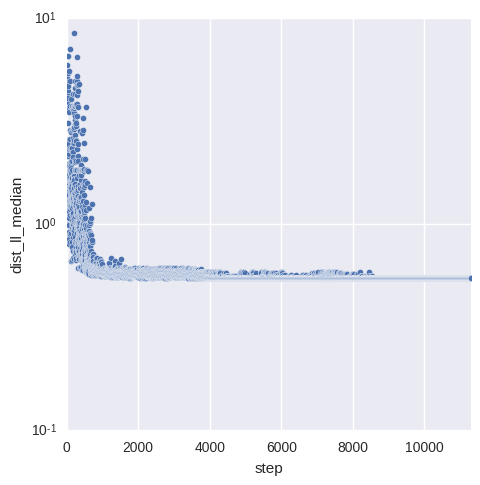

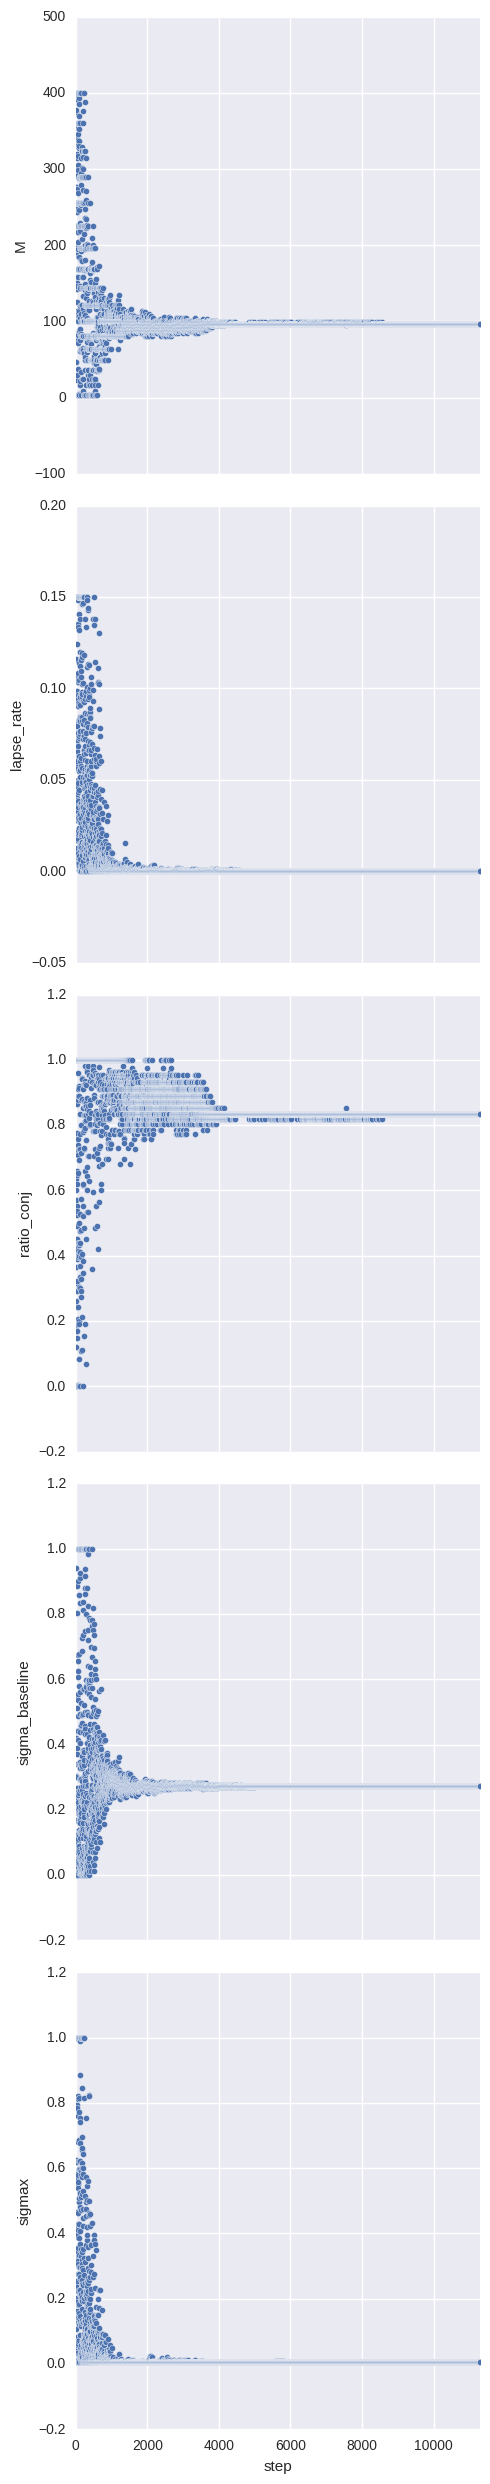

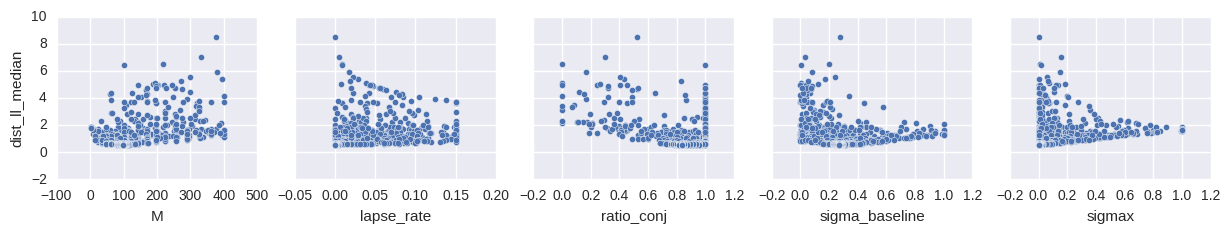

In [10]:
# Learning curve
g = sns.pairplot(df_best_fits,
             y_vars=[metric],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max())
     )
g.set(yscale = 'log')


# Check training of parameters
g = sns.pairplot(df_best_fits,
             y_vars=parameter_names_sorted,
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))


# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
            )



In [11]:
# Filter the start of steps only
df_cmaes_traj = df_best_fits[df_best_fits['step'] < 2000]
result_to_color = np.array(df_cmaes_traj['step'])
# result_to_color = np.array(df_cmaes_traj['dist_nll92'])
# result_to_color = np.log(result_to_color)

parameters = ['M', 'lapse_rate', 'sigma_baseline']
parameters = ['ratio_conj', 'sigmax', 'sigma_baseline']

text = ['> %s' % (x) for x in result_to_color]

trace1 = go.Scatter3d(
        x = df_cmaes_traj[parameters[0]],
        y = df_cmaes_traj[parameters[1]],
        z = df_cmaes_traj[parameters[2]],
        text = text,
        mode = 'markers',
        marker = go.Marker(
            color = result_to_color,
            size = 8,
            colorscale='Viridis',
            opacity=0.7
        )
    )
data = [trace1]
layout = go.Layout(
    title='Landscape for NLL92',
    autosize=False,
    width=700,
    height=700,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
    scene=go.Scene(
        xaxis=go.XAxis(
            title=parameters[0],
        ),
        yaxis=go.YAxis(
            title=parameters[1],
        ),
        zaxis=go.ZAxis(
            title=parameters[2],
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Check parameters values obtained

In [12]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).head(1).median().to_dict()
df_bestparams = df_best_fits.sort_values(by=metric).iloc[0].to_dict()
df_bestparams

{'M': 97.0,
 'dist_ll_median': 0.54851964673871245,
 'lapse_rate': 1.7923394063257611e-13,
 'ratio_conj': 0.83505154639175261,
 'sigma_baseline': 0.27182639948118592,
 'sigmax': 0.0050662509653933152,
 'step': 11169.0}

In [13]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='none',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             num_repetitions=3,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             filter_datapoints_size=2000, 
                             filter_datapoints_selection='random'
                             )

df_bestparams

experiment_parameters.update(df_bestparams)
for key in ['M']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    fit_exp = experiment_launcher.all_vars['fit_exp']
    results = experiment_launcher.all_vars['all_outputs_data']
    plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

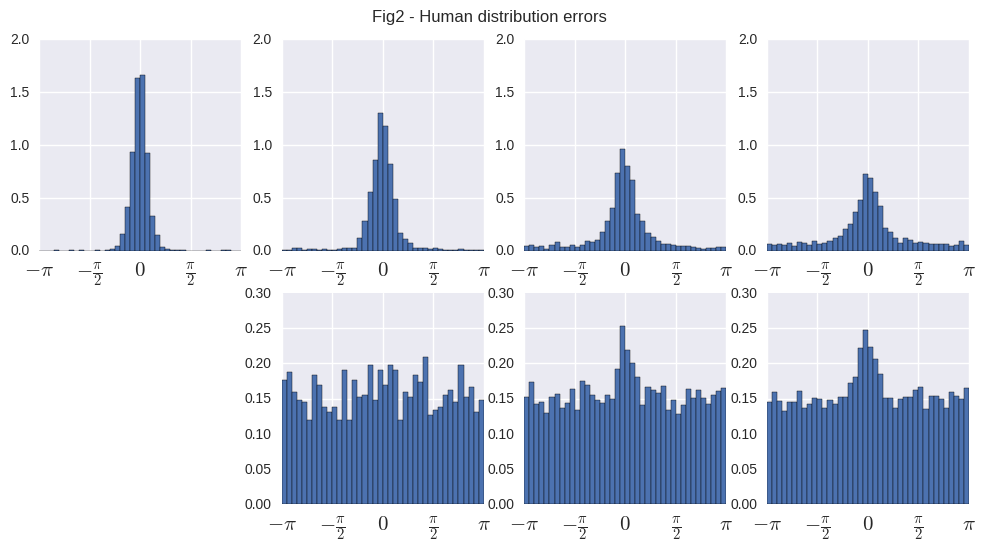

In [14]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

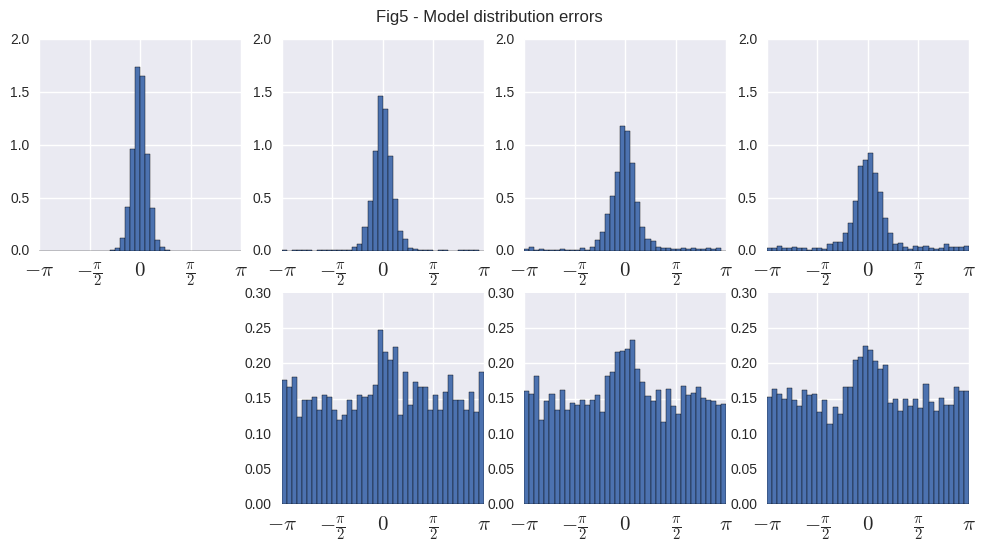

In [15]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

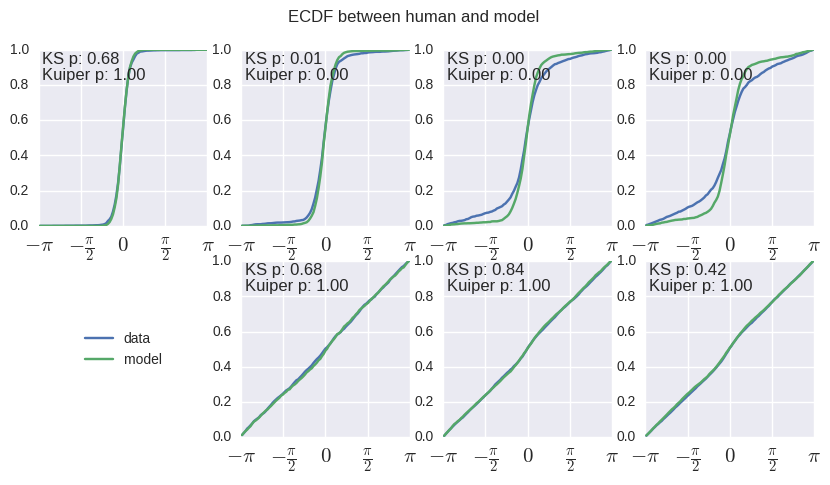

In [16]:
with io.capture_output(display=False, stdout=True) as captured:
    axes, ks_out = plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)
    axes[0, 0].figure.set_size_inches((10, 5))

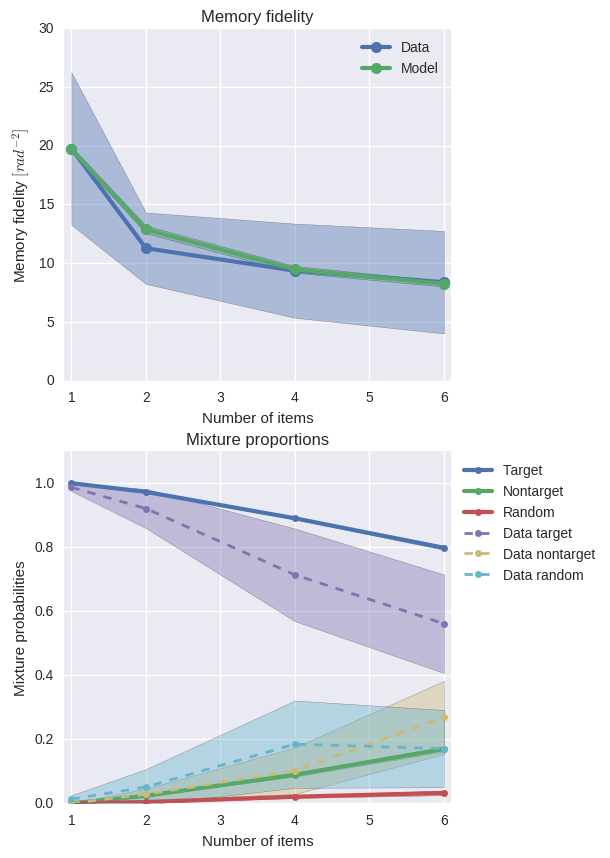

In [22]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)
    axesFig6Fig13[0].figure.set_size_inches((5, 10))

In [18]:
print np.nanmean(results['result_bic'], axis=-1)
print np.nanmean(results['result_ll_sum'], axis=-1)

[ 3459.09226319  5148.77695262  7684.0849544   8031.26990768]
[-1714.55504771 -2559.39739242 -3827.05139331 -4000.64386995]


# Median LL really seems to behave well.

It's simple, doesn't require tuning, and just kinda works.

I know Peter thinks the summed LL is the accurate way to fit data, but it just doesn't work well... 

Basically right now, the LL can be overfitted to a small percentage of the data (see [this random sweep](http://localhost:8997/notebooks/fitexperiment_allt_new_10_2015/notebook_LLlapse_bays09_random_fitexperimentallt_sigmaxMratiolapserate_131015.ipynb)).

Using the median forces the model to do a good job for most of the data, which is what we want as the loglikelihood of the model isn't consistent across different object numbers.



In [19]:
# Store figures
dataio = DataIO(output_folder=os.path.join(os.path.abspath("."), "outputs"), 
                label='thesis_bays09_llmedian', calling_function='')
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fitexperiment_sigmabaseline_cmaes_08_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_9try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217/outputs/thesis_bays09_llmedian-d5e35380-e4cc-4c39-b096-ab922ab9e1a2 ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_9try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_sigmabaseline_cmaes_08_2016/fitexperiment_sigmabaseline_cmaes_08_2016_cmaes_bays09_9try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_9try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/g

In [20]:
axesFig2[0, 0].figure.savefig(dataio.create_formatted_filename("histograms_human_{label}_{unique_id}.pdf"))
axesFig5[0, 0].figure.savefig(dataio.create_formatted_filename("histograms_model_{label}_{unique_id}.pdf"))
axes[0, 0].figure.savefig(dataio.create_formatted_filename("ecdf_model_{label}_{unique_id}.pdf"))
axesFig6Fig13[0].figure.savefig(dataio.create_formatted_filename("emfits_model_{label}_{unique_id}.pdf"))

## Population of best network

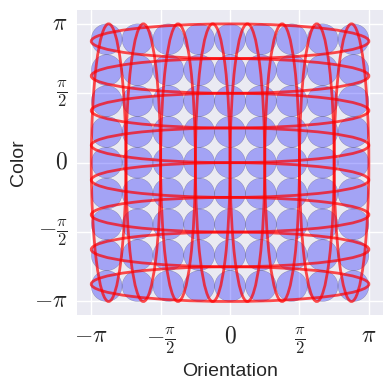

In [117]:
rn = fit_exp.sampler.random_network

axPopulation = rn.plot_coverage_feature_space(
    nb_stddev=1, alpha_ellipses=0.3, specific_neurons=np.arange(81), facecolor='b', lim_factor=1.1)
rn.plot_coverage_feature_space(
    nb_stddev=1, alpha_ellipses=0.7, specific_neurons=np.arange(81, 89), facecolor='none', 
    edgecolor='r', linewidth=2, lim_factor=1.1, ax=axPopulation, scale_height=2)
rn.plot_coverage_feature_space(
    nb_stddev=1, alpha_ellipses=0.7, specific_neurons=np.arange(89, 97), facecolor='none', 
    edgecolor='r', linewidth=2, lim_factor=1.1, ax=axPopulation, scale_width=2)


In [120]:
axPopulation.figure.savefig(dataio.create_formatted_filename("population_{label}_{unique_id}.pdf"))

In [15]:
import scipy.stats as scst

In [183]:
x1 = np.random.randn(1000)/3
x2 = np.random.randn(1000)/2.99 + 0.01
# x2 = 2*np.random.rand(1000)-1

x1s = np.sort(x1)
x2s = np.sort(x2)
xall = np.concatenate([x1s, x2s])

In [184]:
x1cdf = utils.empirical_cdf_samples(x1, bins=101, norm='density')
x2cdf = utils.empirical_cdf_samples(x2, bins=101, norm='density')

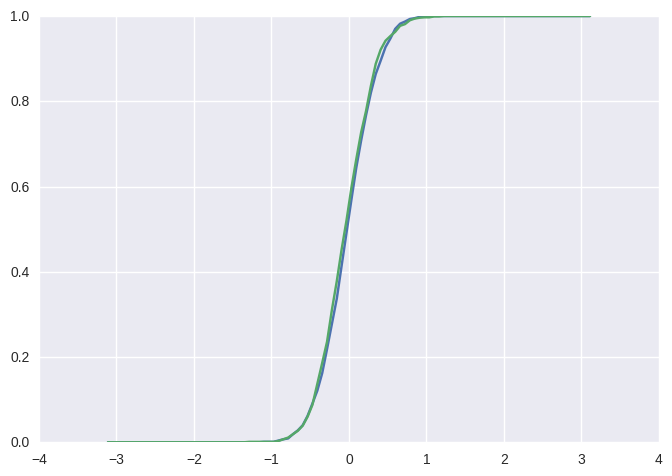

In [185]:
plt.plot(x1cdf['x'], x1cdf['ecdf'])
plt.plot(x2cdf['x'], x2cdf['ecdf'])

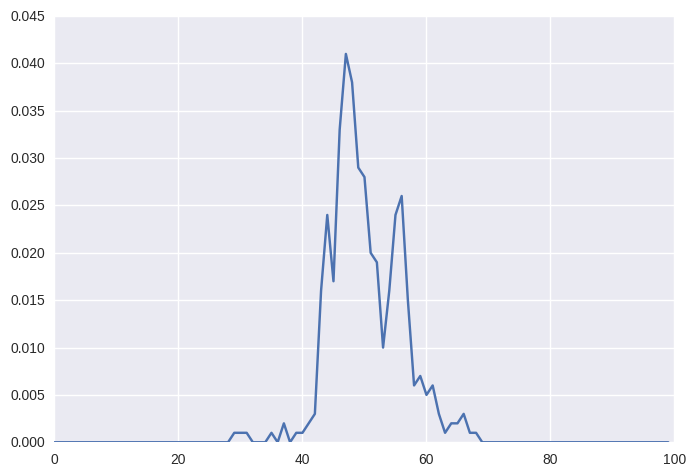

In [186]:
plt.plot(np.abs(x1cdf['ecdf']-x2cdf['ecdf']))

In [187]:
cdf1 = np.searchsorted(x1s, xall, side='right')/(1.*x1s.shape[0])
cdf2 = np.searchsorted(x2s, xall, side='right') / (1.0*x2s.shape[0])
d = np.max(np.absolute(cdf1 - cdf2))
d

0.052999999999999992

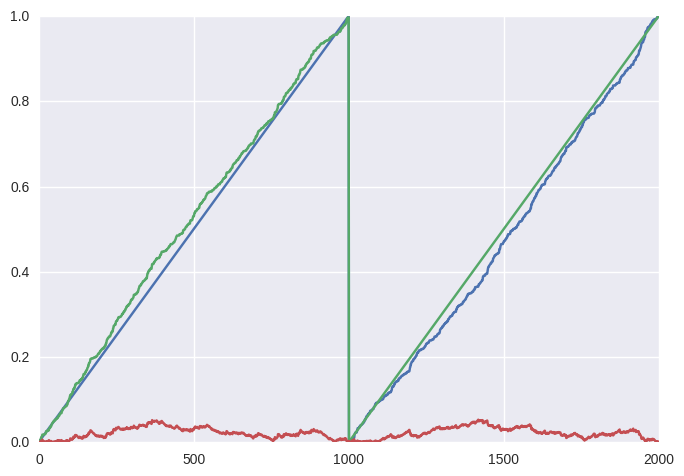

In [188]:
plt.plot(cdf1)
plt.plot(cdf2)
plt.plot(np.absolute(cdf1 - cdf2))

In [189]:
np.sum(np.absolute(cdf1 - cdf2))

43.700000000000003

In [190]:
import scipy.interpolate as spinter
invcdf1 = spinter.interp1d(x1cdf['ecdf'], x1cdf['x'], kind='linear', assume_sorted=True)
invcdf2 = spinter.interp1d(x2cdf['ecdf'], x2cdf['x'], kind='linear', assume_sorted=True)

In [191]:
xx = np.linspace(0, 1., 100)
np.sum((invcdf1(xx) - invcdf2(xx))**2.)

0.10712068261097787

In [23]:
df_bestparams

{'M': 97.0,
 'dist_ll_median': 0.54851964674002218,
 'lapse_rate': 2.6984378589560293e-13,
 'ratio_conj': 0.83505154639175261,
 'sigma_baseline': 0.27182639948116344,
 'sigmax': 0.0050662509660999253,
 'step': 11299.0}

Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -18982.47
Loglikelihood: 189.14
top 90% loglike: 564.06


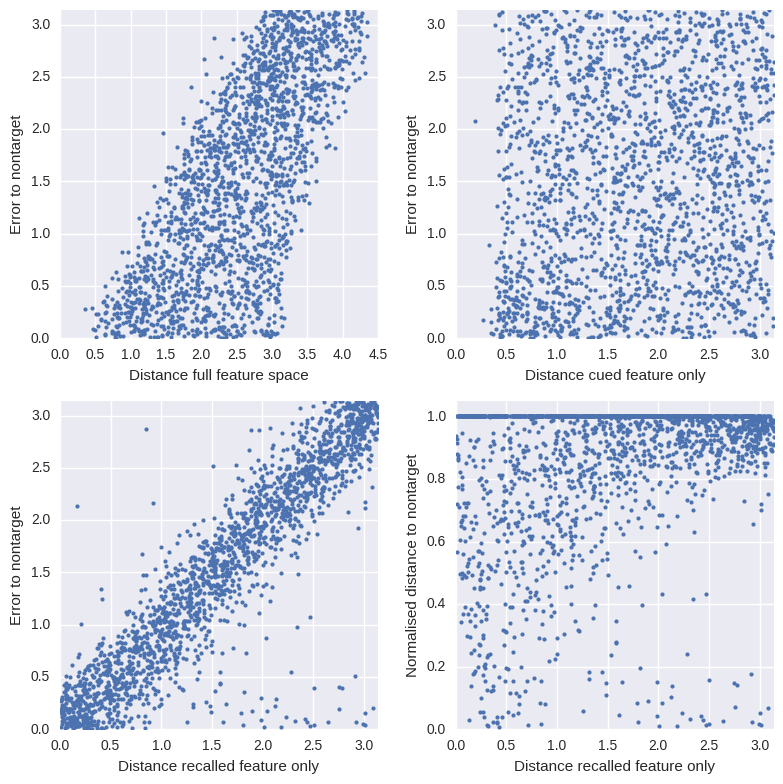

In [28]:
# Reproduce with random data, same parameters
experiment_parameters = dict(action_to_do='launcher_do_simple_run',
                             inference_method='none',
                             selection_method='last',
                             N=2000,
                             T=2,
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             burn_samples=100,
                             ratio_conj=0.7,
                             num_repetitions=1,
                             stimuli_generation_recall='random',
                             enforce_min_distance=0.4,
                             enforce_distance_cued_feature_only=None,
                             autoset_parameters=None,
                             )

experiment_parameters.update(df_bestparams)
for key in ['M']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    sampler = experiment_launcher.all_vars['sampler']

sampler.force_sampling_round()
axes_dist_best_mixed = sampler.plot_bias_close_feature()